In [79]:
import cv2 as cv
import numpy as np
import os

def filtrar_huellas(imagen):
    imagen_gris = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
    
    imagen_filtrada = cv.medianBlur(imagen_gris, 5)
    
    imagen_clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(imagen_filtrada)

    imagen_binaria = cv.adaptiveThreshold(
        imagen_clahe,
        255,
        cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY,
        11,
        10
    )

    imagen_binaria = cv.medianBlur(imagen_binaria, 3)
    
    return imagen_binaria

sample_path = "imagenes_huellas"
files = os.listdir(sample_path)

for file in files:
    dir = os.path.join(sample_path, file)
    file2 = os.listdir(dir)
    ruta = os.path.join(dir, file2[0])
    sample = cv.imread(ruta)  
    sample = filtrar_huellas(sample)

cv.imshow('Huellas', sample)
cv.waitKey(0)
cv.destroyAllWindows()


Imagen cargada correctamente.


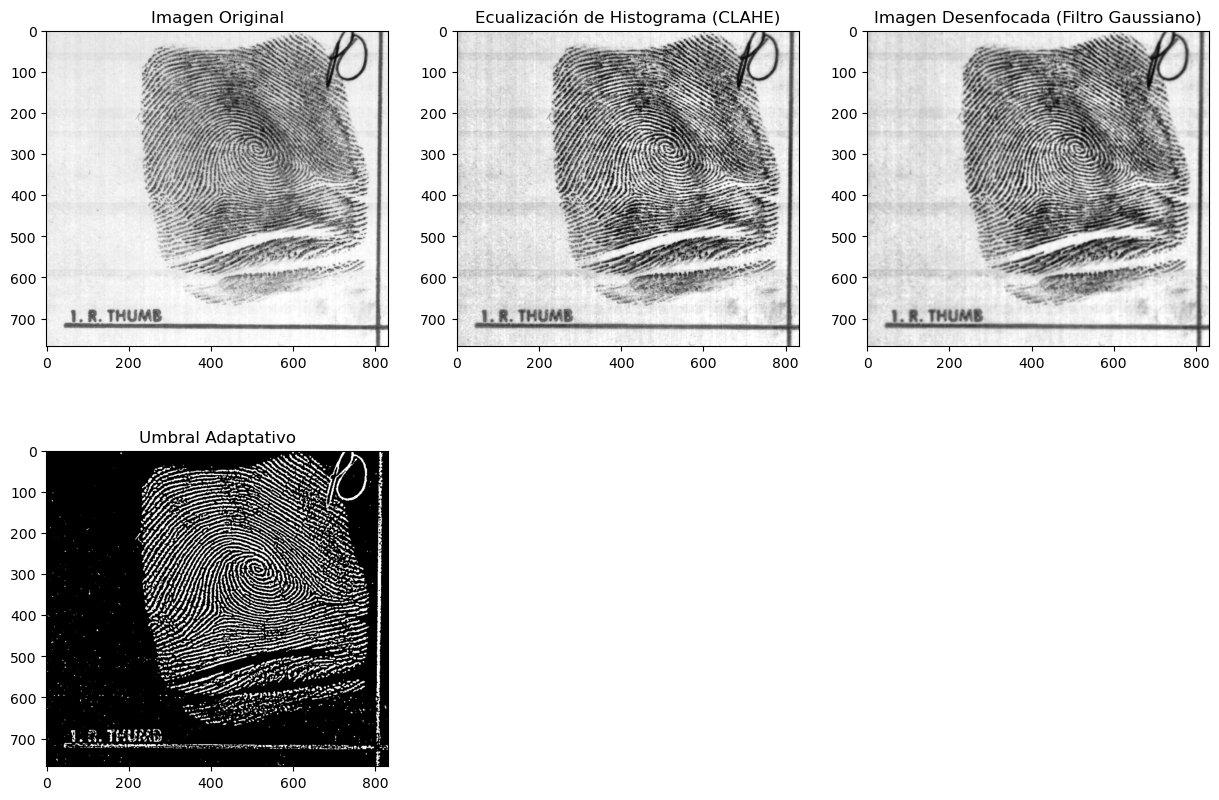

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'imagenes_huellas/crd_0820f/crd_0820s_01.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: No se pudo cargar la imagen.")
else:
    print("Imagen cargada correctamente.")
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image)
    
    blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    
    thresh_image = cv2.adaptiveThreshold(
        blurred_image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,
        10
    )
    
    inverted_image = cv2.bitwise_not(thresh_image)

    cv2.imshow('Imagen', inverted_image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.title('Imagen Original')
    plt.imshow(image, cmap='gray')
    plt.subplot(2, 3, 2)
    plt.title('Ecualización de Histograma (CLAHE)')
    plt.imshow(equalized_image, cmap='gray')
    plt.subplot(2, 3, 3)
    plt.title('Imagen Desenfocada (Filtro Gaussiano)')
    plt.imshow(blurred_image, cmap='gray')
    plt.subplot(2, 3, 4)
    plt.title('Umbral Adaptativo')
    plt.imshow(inverted_image, cmap='gray')
    plt.show()


In [81]:
import cv2
import os

input_folder = 'imagenes_huellas'
output_folder = 'imagenes_recortadas'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

crop_width, crop_height = 550, 550  # Ajusta el tamaño del recorte deseado

for root, dirs, files in os.walk(input_folder):
    for file in files:
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error al leer la imagen {img_path}")
            continue

        _, thresh = cv2.threshold(img, 225, 255, cv2.THRESH_BINARY_INV)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)

            x, y, w, h = cv2.boundingRect(largest_contour)

            center_x, center_y = x + w // 2, y + h // 2

            x_start = max(center_x - crop_width // 2, 0)
            y_start = max(center_y - crop_height // 2, 0)
            x_end = min(center_x + crop_width // 2, img.shape[1])
            y_end = min(center_y + crop_height // 2, img.shape[0])

            if (x_end - x_start) != crop_width:
                x_start = max(0, x_end - crop_width)
            if (y_end - y_start) != crop_height:
                y_start = max(0, y_end - crop_height)

            cropped_img = img[y_start:y_end, x_start:x_end]

            output_path = os.path.join(output_folder, file)
            cv2.imwrite(output_path, cropped_img)
            print(f"Imagen recortada guardada en {output_path}")


Imagen recortada guardada en imagenes_recortadas\crd_0811f_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0811s_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0812f_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0812s_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0813f_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0813s_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0814f_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0814s_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0815f_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0815s_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0816f_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0816s_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0817f_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0817s_01.png
Imagen recortada guardada en imagenes_recortadas\crd_0818f_01.png
Imagen rec

In [82]:
import cv2
import numpy as np
import os

input_dir = 'imagenes_recortadas'
output_dir = 'imagenes_filtradas'

os.makedirs(output_dir, exist_ok=True)

def procesar_imagen(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: No se pudo cargar la imagen {image_path}.")
        return
    
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image)
    
    bilateral_filtered = cv2.bilateralFilter(equalized_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    median_filtered = cv2.medianBlur(bilateral_filtered, 3)
    
    thresh_image = cv2.adaptiveThreshold(
        median_filtered,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        19,
        3
    )
    
    inverted_image = cv2.bitwise_not(thresh_image)
    
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    
    skeleton = np.zeros(cleaned_image.shape, np.uint8)
    img = cleaned_image.copy()
    while True:
        eroded = cv2.erode(img, None)
        temp = cv2.dilate(eroded, None)
        temp = cv2.subtract(img, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break

    cv2.imwrite(output_path, skeleton)
    print(f"Imagen procesada y guardada en {output_path}")

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.png'):
            image_path = os.path.join(root, file)
            output_path = os.path.join(output_dir, file)

            procesar_imagen(image_path, output_path)


Imagen procesada y guardada en imagenes_filtradas\crd_0811f_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0811s_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0812f_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0812s_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0813f_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0813s_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0814f_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0814s_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0815f_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0815s_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0816f_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0816s_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0817f_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0817s_01.png
Imagen procesada y guardada en imagenes_filtradas\crd_0818f_01

## Estrucutra de datos imagenes

In [21]:
import os
import shutil
import numpy as np
import cv2

# Directorio de entrada
input_dir = 'imagenes_filtradas'

# Directorio de salida
output_dir = 'data'
os.makedirs(os.path.join(output_dir, 'train/authenticated'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/rejected'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/authenticated'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/rejected'), exist_ok=True)

# Separar imágenes autenticadas (s) y de prueba (f)
authenticated_images = [img for img in os.listdir(input_dir) if 's' in img]
test_images = [img for img in os.listdir(input_dir) if 'f' in img]

# Mover imágenes autenticadas a train
for image in authenticated_images:
    shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'train/authenticated', image))

# Mover imágenes no vistas (f) a test
for image in test_images:
    shutil.copy(os.path.join(input_dir, image), os.path.join(output_dir, 'test/authenticated', image))


## Aumento del numero de huellas (muestras)

In [24]:
import os
import cv2
import random
import numpy as np

def new_images(input_dir, num_images):
    images = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    
    for image_name in images:
        image_path = os.path.join(input_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        for i in range(num_images):
            img_copy = img.copy()
            
            # Rotación aleatoria
            angle = random.randint(-15, 15)
            h, w = img_copy.shape
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented_img = cv2.warpAffine(img_copy, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Escalado aleatorio
            scale_x = random.uniform(0.7, 1.3)
            scale_y = random.uniform(0.7, 1.3)
            augmented_img = cv2.resize(augmented_img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            
            # Traslación aleatoria
            max_shift = 10  # Máximo desplazamiento en píxeles
            tx = random.randint(-max_shift, max_shift)
            ty = random.randint(-max_shift, max_shift)
            translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
            augmented_img = cv2.warpAffine(augmented_img, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Guardar imagen aumentada en el mismo directorio
            output_name = f"aug_{i}_{image_name}"
            cv2.imwrite(os.path.join(input_dir, output_name), augmented_img)

# Directorios de autenticadas
train_authenticated_dir = 'data/train/authenticated'
test_authenticated_dir = 'data/test/authenticated'
train_rejected_dir = 'data/train/rejected'
test_rejected_dir = 'data/test/rejected'

# Augmentación de imágenes autenticadas
new_images(train_authenticated_dir, num_images=10)
new_images(test_authenticated_dir, num_images=10)



## Aumento de numero de muestras falsas

In [23]:
import os
import cv2
import random
import numpy as np

def new_rejected_images(authenticated_dir, rejected_dir, num_images):
    os.makedirs(rejected_dir, exist_ok=True)
    images = [f for f in os.listdir(authenticated_dir) if f.endswith('.png')]
    
    for image_name in images:
        image_path = os.path.join(authenticated_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        for i in range(num_images):
            rejected_img = img.copy()
            
            # Seleccionar una transformación aleatoria
            transformation = random.choice(['erase', 'blur', 'heavy_noise'])
            
            if transformation == 'erase':
                # Eliminar un cuadrado centrado en la imagen
                h, w = rejected_img.shape
                
                # Tamaño del lado del cuadrado (ajustable)
                square_size = min(w, h) // 8  # Por ejemplo, 1/8 del tamaño menor de la imagen
                
                # Coordenadas del centro de la imagen
                center_x, center_y = w // 2, h // 2
                
                # Coordenadas del cuadrado alrededor del centro
                x1 = center_x - square_size // 2
                y1 = center_y - square_size // 2
                x2 = center_x + square_size // 2
                y2 = center_y + square_size // 2
                
                # Dibujar un cuadrado negro
                cv2.rectangle(rejected_img, (x1, y1), (x2, y2), (0, 0, 0), -1)
                            
            elif transformation == 'blur':
                # Aplicar desenfoque extremo
                kernel_size = random.choice([15, 21, 25])  # Tamaño del kernel
                rejected_img = cv2.GaussianBlur(rejected_img, (kernel_size, kernel_size), 0)
            
            elif transformation == 'heavy_noise':
                # Agregar ruido severo
                noise = np.random.randint(0, 25, rejected_img.shape, dtype='uint8')
                rejected_img = cv2.add(rejected_img, noise)
            
            # Guardar imagen generada
            output_name = f"rej_complex_{i}_{image_name}"
            cv2.imwrite(os.path.join(rejected_dir, output_name), rejected_img)

# Directorios
train_authenticated_dir = 'data/train/authenticated'
train_rejected_dir = 'data/train/rejected'

test_authenticated_dir = 'data/test/authenticated'
test_rejected_dir = 'data/test/rejected'

# Generar datos rechazados más complejos
new_rejected_images(train_authenticated_dir, train_rejected_dir, num_images=1)
new_rejected_images(test_authenticated_dir, test_rejected_dir, num_images=1)

new_images(train_rejected_dir, num_images=1)
new_images(test_rejected_dir, num_images=1)


## Etiquetamos las huellas

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformaciones
transform = transforms.Compose([
    transforms.Grayscale(),  # Asegurar escala de grises
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Cargar datasets
train_dataset = datasets.ImageFolder('data/train', transform=transform)
test_dataset = datasets.ImageFolder('data/test', transform=transform)

# Cargar en DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) # Batch_size en funcion del tamaño de los datos
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Etiquetas automáticas
print(train_dataset.class_to_idx)  # {'authenticated': 0, 'rejected': 1}
print(test_dataset.class_to_idx, "\n")  # {'authenticated': 0, 'rejected': 1}

# Verificar tamaño de los datos
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)  # torch.Size([32, 1, 128, 128]) torch.Size([32])
print(labels, "\n")

images, labels = next(iter(test_loader))
print(images.shape, labels.shape)  # torch.Size([32, 1, 128, 128]) torch.Size([32])
print(labels)

{'authenticated': 0, 'rejected': 1}
{'authenticated': 0, 'rejected': 1} 

torch.Size([8, 1, 128, 128]) torch.Size([8])
tensor([1, 1, 0, 1, 1, 1, 1, 0]) 

torch.Size([8, 1, 128, 128]) torch.Size([8])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [5]:
# CNN

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Definir la arquitectura de la CNN
class FingerprintCNN(nn.Module):
    def __init__(self):
        super(FingerprintCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1 = imágenes en escala de grises
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce tamaño a la mitad
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),  # Ajusta 16x16 si las imágenes son de 128x128
            nn.ReLU(),
            nn.Dropout(0.5),  # Ayuda a evitar el sobreajuste
            nn.Linear(256, 1),  # Una salida para clasificación binaria
            nn.Sigmoid() # Salida entre 0 y 1
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [6]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Definir el modelo, la función de pérdida y el optimizador
model = FingerprintCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss para clasificación binaria
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo de entrenamiento
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Poner el modelo en modo entrenamiento
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convertir etiquetas a float
        
        # Adelante
        outputs = model(images).squeeze(1)  # Eliminar dimensión extra de la salida
        loss = criterion(outputs, labels)
        
        # Atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Usando dispositivo: cuda
Epoch 1/50, Loss: 0.6476
Epoch 2/50, Loss: 0.5143
Epoch 3/50, Loss: 0.5047
Epoch 4/50, Loss: 0.4159
Epoch 5/50, Loss: 0.3638
Epoch 6/50, Loss: 0.3016
Epoch 7/50, Loss: 0.1687
Epoch 8/50, Loss: 0.0860
Epoch 9/50, Loss: 0.1703
Epoch 10/50, Loss: 0.1695
Epoch 11/50, Loss: 0.0617
Epoch 12/50, Loss: 0.0356


KeyboardInterrupt: 

In [89]:
# Modo evaluación
model.eval()
correct = 0
total = 0

with torch.no_grad():  # No necesitamos gradientes para evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze(1)
        predicted = (outputs > 0.8).float()  # Umbral: salida > 0.8 es 1 (authenticated)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy en conjunto de prueba: {accuracy:.2f}%")
print(f"Total de imágenes: {total}, Correctas: {correct}, Incorrectas: {total - correct}")


Accuracy en conjunto de prueba: 93.64%
Total de imágenes: 220, Correctas: 206, Incorrectas: 14


Shape de las imágenes: torch.Size([8, 1, 128, 128])
Etiquetas: tensor([0, 0, 1, 0, 1, 1, 1, 1])
Etiqueta: 0, Clase: authenticated
Etiqueta: 0, Clase: authenticated
Etiqueta: 1, Clase: rejected
Etiqueta: 0, Clase: authenticated
Etiqueta: 1, Clase: rejected
Etiqueta: 1, Clase: rejected
Etiqueta: 1, Clase: rejected
Etiqueta: 1, Clase: rejected


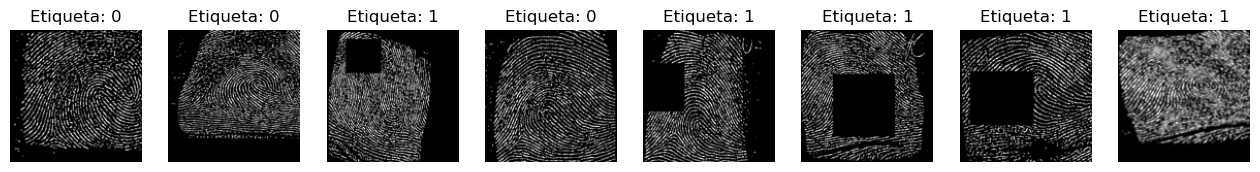

In [90]:
import matplotlib.pyplot as plt

# Visualizar un lote del conjunto de entrenamiento
images, labels = next(iter(train_loader))
print("Shape de las imágenes:", images.shape)  # torch.Size([batch_size, 1, 128, 128])
print("Etiquetas:", labels)  # Ejemplo: tensor([0, 1, 0, 0, 1])

# Mostrar las primeras 8 imágenes con sus etiquetas
fig, axes = plt.subplots(1, 8, figsize=(16, 4))
for i, ax in enumerate(axes):
    img = images[i].squeeze().numpy()  # Convertir tensor a numpy
    label = labels[i].item()
    # Clase basada en class_to_idx
    clase = [k for k, v in train_dataset.class_to_idx.items() if v == label][0]
    print(f"Etiqueta: {label}, Clase: {clase}")
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Etiqueta: {label}")
    ax.axis('off')
plt.show()
